In [ ]:
import numpy as np
import math
import torch
import torchvision
import torchvision.transforms as transforms


from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Загрузка датасета CIFAR10

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Определение загрузчиков данных (оставим значение батча равное 4, чтобы не приходилось долго ждать завершение обучения, т.к. загрузчики отрабатывают достаточно долго)

In [ ]:
batch_size=4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

## Визуализация нескольких изображений с метками класса

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6667,  ..., 0.3608, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.9961,  ..., 0.4667, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6471,  ..., 0.4824, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.6157,  ..., 0.5294, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6353,  ..., 0.2745, 0.0000, 0.

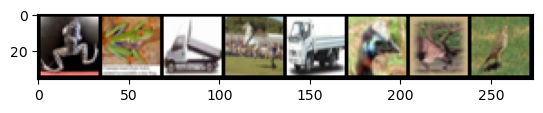

frog  frog  truck horse truck bird  deer  bird 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    print(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Теперь посмотрим на то, как выглядит картинка в виде массива данных

In [ ]:
images[0]

tensor([[[0.5529, 0.5725, 0.5804,  ..., 0.5882, 0.4824, 0.4431],
         [0.6000, 0.6078, 0.6078,  ..., 0.6078, 0.4706, 0.4157],
         [0.5882, 0.5961, 0.5922,  ..., 0.6039, 0.4706, 0.4196],
         ...,
         [0.2510, 0.2275, 0.2235,  ..., 0.2627, 0.3490, 0.4118],
         [0.2235, 0.2275, 0.2549,  ..., 0.3569, 0.4471, 0.5333],
         [0.2510, 0.2471, 0.2627,  ..., 0.3216, 0.4902, 0.5373]],

        [[0.7412, 0.7490, 0.7490,  ..., 0.7569, 0.6235, 0.5608],
         [0.7804, 0.7804, 0.7725,  ..., 0.7765, 0.5961, 0.5020],
         [0.7882, 0.7843, 0.7765,  ..., 0.7725, 0.6118, 0.5137],
         ...,
         [0.2902, 0.2431, 0.2196,  ..., 0.2588, 0.3176, 0.4196],
         [0.2314, 0.2314, 0.2549,  ..., 0.3294, 0.4039, 0.5373],
         [0.2549, 0.2471, 0.2667,  ..., 0.2902, 0.4510, 0.5490]],

        [[0.8235, 0.8235, 0.8235,  ..., 0.8471, 0.6941, 0.6118],
         [0.8588, 0.8510, 0.8392,  ..., 0.8667, 0.6471, 0.5255],
         [0.8784, 0.8706, 0.8588,  ..., 0.8588, 0.6667, 0.

### Видно, что картинка-трехканальная

# Импорт библиотек из pytorch и реализация класса нейронной сети

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

## Класс EarlyStopping

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0.01):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, losses):
        if (losses[0] - losses[1])/losses[0] <= self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

## Класс нейронной сети. Добавлена возможность выбора слоя свертки, maxpooling, softmax, ошибки crossentropy. По сути, это универсальный каркас, с помощью которого можно решать задачи регрессии и классификации на табличных данных, а также работать с классификацией изображений.

In [ ]:
class CfarClassifier(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.previous_shape = args[0].shape if len(args[0].shape) == 3 else args[0][np.newaxis, :].shape
        self.layers = nn.ModuleList([self.choose_layer(**arg) for arg in args[1]])
        print(args[0].shape)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def predict(self, X):
        return [x.argmax() for x in self.forward(X)]

    def train(self, X_y, optimizer='Adam', lr=0.001, epochs=100, tolerance=7, min_delta=0.001, batch=None, val_part=0.1):

        self.optimizer = self.choose_optimizer(optimizer=optimizer, lr=lr)
        self.erls = EarlyStopping(tolerance=tolerance, min_delta=min_delta)
        self.loss = self.choose_loss(loss='CrossEntropy')
        self.train_epoch_losses = []

        for epoch in range(epochs):

            step = 0

            for i, x_y in enumerate(X_y, 0):
                x_batch, y_batch = x_y
                step += 1

                self.optimizer.zero_grad()

                x_batch, y_batch = x_y

                preds = self.forward(x_batch)

                loss_val = self.loss(preds, y_batch)
                loss_val.backward()

                self.optimizer.step()

            self.train_epoch_losses.append(self.loss(self.forward(x_batch), y_batch).item())

            print(f'epoch {epoch + 1}/{epochs}: train_loss={self.train_epoch_losses[-1]}')

            if len(self.train_epoch_losses) > 2:
                self.erls(self.train_epoch_losses[-2:])
                if self.erls.early_stop:
                    print(f'Early Stop at epoch {epoch + 1}')
                    break

        return 0


    def choose_layer(self, layer, in_features=None, out_features=None, dropout=None,
                     in_channels=None, out_channels=None, kernel=None, stride=None, padding=None):
        if layer == 'linear':
            assert (in_features is not None) and (out_features is not None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Linear(in_features=self.previous_shape if in_features == 'prev' else in_features,
                             out_features=out_features, bias=True)
        elif layer == 'flatten':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            self.previous_shape = math.prod(self.previous_shape)
            return nn.Flatten()
        elif layer == 'softmax':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Softmax(dim=1)
        elif layer == 'tanh':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Tanh()
        elif layer == 'sigmoid':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Sigmoid()
        elif layer == 'relu':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.ReLU()
        elif layer == 'dropout':
            assert (in_features is None) and (out_features is None) and (dropout is not None) and \
            (in_channels is None) and (out_channels is None) and (kernel is None) and \
            (stride is None) and (padding is None)
            return nn.Dropout(p=dropout)
        elif layer == 'conv2d':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is not None) and (out_channels is not None) and (kernel is not None) and\
            (stride is not None) and (padding is not None)
            self.previous_shape = self.calc_out_shape_conv(self.previous_shape[1], self.previous_shape[2],
                                                 out_channels, kernel, stride, padding)
            return nn.Conv2d(in_channels, out_channels, kernel, stride=stride, padding=padding)
        elif layer == 'max_pooling':
            assert (in_features is None) and (out_features is None) and (dropout is None) and \
            (in_channels is None) and (out_channels is None) and (kernel is not None) and\
            (stride is not None) and (padding is not None)
            self.previous_shape = self.calc_out_shape_pool(self.previous_shape[1], self.previous_shape[2],
                                                 self.previous_shape[0], kernel, stride, padding)
            return nn.MaxPool2d(kernel, stride=stride, padding=padding)

    def calc_out_shape_conv(self, H_in, W_in, out_channels, kernel_size, stride, padding):
        H_out = ((H_in - kernel_size + 2 * padding) // stride) + 1
        W_out = ((W_in - kernel_size + 2 * padding) // stride) + 1
        out_shape = (out_channels, H_out, W_out)

        return out_shape

    def calc_out_shape_pool(self, H_in, W_in, out_channels, kernel_size, stride, padding):
        H_out = ((H_in + 2 * padding - kernel_size) // stride) + 1
        W_out = ((W_in + 2 * padding - kernel_size) // stride) + 1
        out_shape = (out_channels, H_out, W_out)

        return out_shape

    def choose_optimizer(self, optimizer='Adam', lr=0.01):
        if optimizer=='SGD':
            return torch.optim.SGD(self.parameters(), lr=lr)
        elif optimizer=='Adam':
            return torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer=='RMSprop':
            return torch.optim.RMSprop(self.parameters(), lr=lr)

    def choose_loss(self, loss='CrossEntropy'):
        if loss=='RMSE':
            def _rmse(pred, target):
                return torch.sqrt(((pred - target) ** 2).mean())
            return _rmse
        elif loss=='MSE':
            def _mse(pred, target):
                return ((pred - target) ** 2).mean()
            return _mse
        elif loss=='MAE':
            def _mae(pred, target):
                return torch.abs(pred - target).mean()
            return _mae
        elif loss=='CrossEntropy':
            return nn.CrossEntropyLoss()

# Инициализация нейронной сети.

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
Adam_network = CfarClassifier(images[0],
                               (dict(layer='conv2d', in_channels=3, out_channels=6, kernel=5, stride=1, padding=0),
                                dict(layer='relu'),
                                dict(layer='max_pooling', kernel=2, stride=1, padding=0),
                                dict(layer='conv2d', in_channels=6, out_channels=16, kernel=5, stride=1, padding=0),
                                dict(layer='relu'),
                                dict(layer='max_pooling', kernel=2, stride=1, padding=0),
                                dict(layer='flatten'),
                                dict(layer='linear', in_features='prev', out_features=120),
                                dict(layer='relu'),
                                dict(layer='linear', in_features=120, out_features=84),
                                dict(layer='relu'),
                                dict(layer='linear', in_features=84, out_features=10)))

torch.Size([3, 32, 32])


## Обучение нейронной сети с оптимизатором Adam

In [ ]:
Adam_network.train(trainloader)

epoch 1/100: train_loss=1.3182036876678467
epoch 2/100: train_loss=1.0261229276657104
epoch 3/100: train_loss=1.010232925415039
epoch 4/100: train_loss=1.2957909107208252
epoch 5/100: train_loss=0.5871378183364868
epoch 6/100: train_loss=0.20551472902297974
epoch 7/100: train_loss=0.3074181079864502
epoch 8/100: train_loss=0.37823963165283203
epoch 9/100: train_loss=0.8245628476142883
epoch 10/100: train_loss=0.8905535340309143
epoch 11/100: train_loss=1.1096808910369873
epoch 12/100: train_loss=0.1937500685453415
epoch 13/100: train_loss=0.46251294016838074
Early Stop at epoch 13


0

## Обучение нейронной сети с оптимизатором SGD

In [ ]:
SGD_network = CfarClassifier(images[0],
                               (dict(layer='conv2d', in_channels=3, out_channels=6, kernel=5, stride=1, padding=0),
                                dict(layer='relu'),
                                dict(layer='max_pooling', kernel=2, stride=1, padding=0),
                                dict(layer='conv2d', in_channels=6, out_channels=16, kernel=5, stride=1, padding=0),
                                dict(layer='relu'),
                                dict(layer='max_pooling', kernel=2, stride=1, padding=0),
                                dict(layer='flatten'),
                                dict(layer='linear', in_features='prev', out_features=120),
                                dict(layer='relu'),
                                dict(layer='linear', in_features=120, out_features=84),
                                dict(layer='relu'),
                                dict(layer='linear', in_features=84, out_features=10)))

SGD_network.train(trainloader, optimizer='SGD')

torch.Size([3, 32, 32])
epoch 1/100: train_loss=2.199282646179199
epoch 2/100: train_loss=1.8057489395141602
epoch 3/100: train_loss=0.7504534125328064
epoch 4/100: train_loss=1.1761903762817383
epoch 5/100: train_loss=1.4780750274658203
epoch 6/100: train_loss=0.816305935382843
epoch 7/100: train_loss=1.0095034837722778
epoch 8/100: train_loss=1.1481159925460815
epoch 9/100: train_loss=0.6402647495269775
epoch 10/100: train_loss=0.17170479893684387
epoch 11/100: train_loss=1.1992450952529907
epoch 12/100: train_loss=1.275217056274414
epoch 13/100: train_loss=0.15955255925655365
epoch 14/100: train_loss=0.7863974571228027
Early Stop at epoch 14


0

# Оценка на тестовом множестве

In [ ]:
# Adam

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

correct = 0
total = 0

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        predictions = Adam_network.predict(images)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        total += labels.size(0)
        for pred, true in zip(predictions, labels):
            if pred == true:
                correct += 1

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %\n\n')
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 53 %


Accuracy for class: plane is 65.5 %
Accuracy for class: car   is 59.6 %
Accuracy for class: bird  is 38.6 %
Accuracy for class: cat   is 30.6 %
Accuracy for class: deer  is 53.3 %
Accuracy for class: dog   is 40.0 %
Accuracy for class: frog  is 70.3 %
Accuracy for class: horse is 55.2 %
Accuracy for class: ship  is 58.4 %
Accuracy for class: truck is 61.0 %


In [ ]:
# SGD

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

correct = 0
total = 0

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        predictions = SGD_network.predict(images)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
        total += labels.size(0)
        for pred, true in zip(predictions, labels):
            if pred == true:
                correct += 1

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %\n\n')
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 57 %


Accuracy for class: plane is 61.3 %
Accuracy for class: car   is 64.7 %
Accuracy for class: bird  is 49.1 %
Accuracy for class: cat   is 39.8 %
Accuracy for class: deer  is 51.6 %
Accuracy for class: dog   is 35.9 %
Accuracy for class: frog  is 53.8 %
Accuracy for class: horse is 75.6 %
Accuracy for class: ship  is 73.5 %
Accuracy for class: truck is 68.2 %
